
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

In [1]:
# load libraries
# %pip install mlxtend
# %pip install lightgbm

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
num_filter = 80
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
# index_name = 'record'
# y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [4]:
%cd "D:\USC\4th semester\DSO562 fraud"

D:\USC\4th semester\DSO562 fraud


In [5]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'training_pj3.csv'
    df = pd.read_csv(file_name,converters={'Merchnum': lambda x: str(x),
                                       'Merch zip': lambda x: str(x),
                                       'card_zip': lambda x: str(x),
                                       'merch_zip': lambda x: str(x)})
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
    
    """
    Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
    Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
    """
#     filter_score = pd.concat([filter_score,new])
    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on training_pj3.csv size is (96397, 561)
100
200
300
400
500
training_pj3.csv                 variable     score
9                  Fraud  1.000000
272     card_zip_total_7  0.684742
107   card_merch_total_7  0.681080
263     card_zip_total_3  0.677675
98    card_merch_total_3  0.675092
116  card_merch_total_14  0.674967
208   card_state_total_3  0.674203
281    card_zip_total_14  0.672290
162     card_des_total_7  0.671267
217   card_state_total_7  0.669699
226  card_state_total_14  0.668943
171    card_des_total_14  0.665538
153     card_des_total_3  0.661331
254     card_zip_total_1  0.660577
169      card_des_max_14  0.659166
199   card_state_total_1  0.659137
125  card_merch_total_30  0.658364
89    card_merch_total_1  0.658215
279      card_zip_max_14  0.657904
270       card_zip_max_7  0.657523
Wall time: 20 s


In [6]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [7]:
filter_score.head(30)

,variable,score
9,Fraud,1.000000
272,card_zip_total_7,0.684742
107,card_merch_total_7,0.681080
263,card_zip_total_3,0.677675
98,card_merch_total_3,0.675092
116,card_merch_total_14,0.674967
208,card_state_total_3,0.674203
281,card_zip_total_14,0.672290
162,card_des_total_7,0.671267
217,card_state_total_7,0.669699


In [8]:
filter_score.tail(10)

,variable,score
532,card_des_count_1_by_30,0.083857
543,card_zip_count_1_by_14,0.080453
541,card_zip_count_0_by_30,0.080449
535,card_state_count_0_by_30,0.076421
524,card_merch_count_1_by_7,0.069865
525,card_merch_count_1_by_14,0.059937
542,card_zip_count_1_by_7,0.055968
560,RANDOM,0.044484
536,card_state_count_1_by_7,0.040234
7,Transtype,0.000000


In [9]:
filter_score.shape

(561, 2)

In [10]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['card_zip_total_7', 'card_merch_total_7', 'card_zip_total_3', 'card_merch_total_3', 'card_merch_total_14', 'card_state_total_3', 'card_zip_total_14', 'card_des_total_7', 'card_state_total_7', 'card_state_total_14', 'card_des_total_14', 'card_des_total_3', 'card_zip_total_1', 'card_des_max_14', 'card_state_total_1', 'card_merch_total_30', 'card_merch_total_1', 'card_zip_max_14', 'card_zip_max_7', 'card_des_total_30', 'card_des_max_7', 'card_zip_total_30', 'card_des_max_30', 'card_merch_max_14', 'card_zip_max_30', 'card_merch_max_7', 'card_des_max_3', 'card_zip_max_3', 'card_merch_max_30', 'card_state_max_3', 'card_state_max_7', 'card_merch_max_3', 'card_des_total_1', 'card_state_total_30', 'card_state_max_14', 'card_des_max_1', 'card_zip_max_1', 'des_state_total_3', 'card_state_max_1', 'Merch description_total_3', 'des_zip_total_3', 'card_merch_max_1', 'merch_des_total_3', 'merch_state_total_3', 'des_state_total_1', 'Merch description_total_1', 'card_merch_total_0', 'card

In [11]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_zip_total_7,card_merch_total_7,card_zip_total_3,card_merch_total_3,card_merch_total_14,card_state_total_3,card_zip_total_14,card_des_total_7,card_state_total_7,card_state_total_14,...,card_merch_avg_30,card_zip_avg_7,card_des_avg_14,merch_state_max_1,card_zip_avg_3,des_state_max_3,card_merch_avg_3,card_des_avg_3,des_zip_max_3,card_merch_avg_14
Recnum,,,,,,,,,,,,,,,,,,,,,
2995,1023.04,1023.04,174.20,174.20,1023.04,174.20,1023.04,1023.04,1023.04,1023.04,...,341.013333,341.013333,341.013333,174.20,174.200,2454.99,174.200,174.200,2454.99,341.013333
2996,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,...,250.000000,250.000000,250.000000,250.00,250.000,250.00,250.000,250.000,250.00,250.000000
2997,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,...,38.425000,38.425000,38.425000,999.90,38.425,1097.60,38.425,38.425,1097.60,38.425000
2998,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,...,1269.000000,1269.000000,1269.000000,1269.00,1269.000,2237.00,1269.000,1269.000,2237.00,1269.000000
2999,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,...,288.380000,288.380000,288.380000,601.52,288.380,601.52,288.380,288.380,601.52,288.380000


In [12]:
df_keep.shape

(80983, 80)

In [13]:
Y.head()

,Fraud
Recnum,
2995,0
2996,0
2997,0
2998,0
2999,0


In [14]:
Y = Y.values
Y_save = Y.copy()

In [15]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [16]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:42.994531


In [17]:
print(X.shape,Y.shape)

(80983, 80) (80983, 1)


In [18]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [19]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [20]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [21]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=10,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   41.6s finished

[2022-04-11 20:01:52] Features: 1/20 -- score: 0.6151697407110398[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   40.8s finished

[2022-04-11 20:02:33] Features: 2/20 -- score: 0.6683507083667468[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   43.6s finished

[2022-04-11 20:03:17] Features: 3/20 -- score: 0.6821438118150227[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  77 out o

Wall time: 23min 57s


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:  1.7min finished

[2022-04-11 20:25:08] Features: 20/20 -- score: 0.6891205560010693

SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=3),
                          k_features=20, n_jobs=-1,
                          scoring=<function fdr at 0x00000229FA9AC620>,
                          verbose=2)

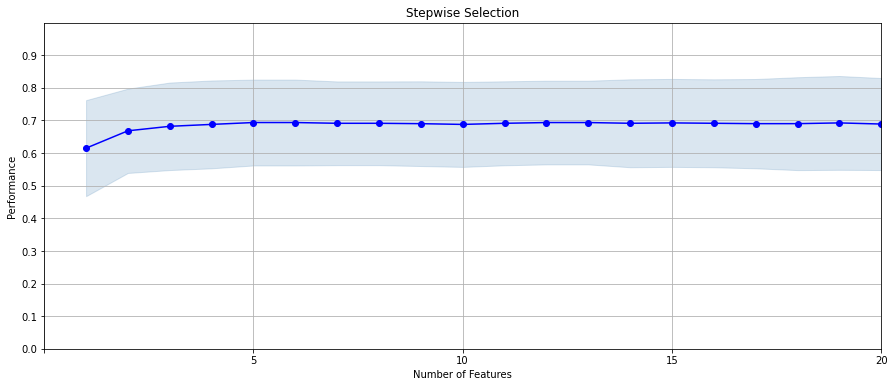

In [22]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [23]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [24]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])

In [25]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(2,)","[0.4482758620689655, 0.5632183908045977, 0.827...",0.61517,"(card_zip_total_3,)",0.109339,0.147216,0.0490721,1.0,card_zip_total_3
2,"(2, 64)","[0.6206896551724138, 0.6206896551724138, 0.724...",0.668351,"(card_zip_total_3, card_state_max_30)",0.0959979,0.129253,0.0430844,2.0,card_state_max_30
3,"(2, 4, 64)","[0.6206896551724138, 0.6091954022988506, 0.804...",0.682144,"(card_zip_total_3, card_merch_total_14, card_s...",0.09964,0.134157,0.0447189,3.0,card_merch_total_14
4,"(2, 4, 11, 64)","[0.6206896551724138, 0.6091954022988506, 0.793...",0.687998,"(card_zip_total_3, card_merch_total_14, card_d...",0.0999992,0.13464,0.0448802,4.0,card_des_total_3
5,"(2, 4, 11, 49, 64)","[0.632183908045977, 0.6091954022988506, 0.7931...",0.693745,"(card_zip_total_3, card_merch_total_14, card_d...",0.0977862,0.131661,0.0438869,5.0,card_des_total_0
6,"(2, 4, 11, 47, 49, 64)","[0.632183908045977, 0.6091954022988506, 0.7931...",0.693745,"(card_zip_total_3, card_merch_total_14, card_d...",0.0977862,0.131661,0.0438869,6.0,card_state_total_0
7,"(2, 4, 11, 15, 47, 49, 64)","[0.632183908045977, 0.6091954022988506, 0.7931...",0.691393,"(card_zip_total_3, card_merch_total_14, card_d...",0.0953321,0.128357,0.0427855,7.0,card_merch_total_30
8,"(2, 4, 11, 15, 47, 49, 51, 64)","[0.632183908045977, 0.6091954022988506, 0.7931...",0.691393,"(card_zip_total_3, card_merch_total_14, card_d...",0.0953321,0.128357,0.0427855,8.0,card_zip_total_0
9,"(2, 4, 11, 15, 46, 47, 49, 51, 64)","[0.632183908045977, 0.6091954022988506, 0.7931...",0.690243,"(card_zip_total_3, card_merch_total_14, card_d...",0.0964419,0.129851,0.0432836,9.0,card_merch_total_0
10,"(2, 4, 11, 15, 46, 47, 49, 51, 64, 69)","[0.6206896551724138, 0.6091954022988506, 0.793...",0.687958,"(card_zip_total_3, card_merch_total_14, card_d...",0.0967381,0.13025,0.0434165,10.0,card_zip_avg_14


In [26]:
ordered_vars_FS.to_csv('VarsFS.csv', index=False)

In [27]:
ordered_vars_FS['variable name']

1        card_zip_total_3
2       card_state_max_30
3     card_merch_total_14
4        card_des_total_3
5        card_des_total_0
6      card_state_total_0
7     card_merch_total_30
8        card_zip_total_0
9      card_merch_total_0
10        card_zip_avg_14
11     card_merch_total_3
12      card_merch_avg_14
13         card_zip_avg_7
14      card_state_max_14
15      card_merch_avg_30
16        card_zip_avg_30
17          des_zip_max_3
18      merch_state_max_0
19        des_state_max_3
20    card_state_total_30
Name: variable name, dtype: object

In [28]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)

In [29]:
vars_keep

1        card_zip_total_3
2       card_state_max_30
3     card_merch_total_14
4        card_des_total_3
5        card_des_total_0
6      card_state_total_0
7     card_merch_total_30
8        card_zip_total_0
9      card_merch_total_0
10        card_zip_avg_14
11     card_merch_total_3
12      card_merch_avg_14
13         card_zip_avg_7
14      card_state_max_14
15      card_merch_avg_30
16        card_zip_avg_30
17          des_zip_max_3
18      merch_state_max_0
19        des_state_max_3
20    card_state_total_30
Name: variable name, dtype: object

In [30]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_zip_total_3',
 'card_state_max_30',
 'card_merch_total_14',
 'card_des_total_3',
 'card_des_total_0',
 'card_state_total_0',
 'card_merch_total_30',
 'card_zip_total_0',
 'card_merch_total_0',
 'card_zip_avg_14',
 'card_merch_total_3',
 'card_merch_avg_14',
 'card_zip_avg_7',
 'card_state_max_14',
 'card_merch_avg_30',
 'card_zip_avg_30',
 'des_zip_max_3',
 'merch_state_max_0',
 'des_state_max_3',
 'card_state_total_30',
 'Recnum',
 'Fraud']

In [31]:
df = pd.read_csv(file_name)

In [32]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(96397, 22)


In [33]:
df_keep.to_csv('vars_final.csv',index=False)

In [34]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:24:51.903473
